In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Imputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

# Analysis data

In [2]:
train_df = pd.read_csv('data/train.csv')

In [3]:
train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
train_df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [6]:
train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [7]:
train_df['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [8]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
X = train_df.copy()

In [10]:
class DataFrameSelection(BaseEstimator, TransformerMixin):
    def __init__(self, attrs):
        self.attrs = attrs
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.attrs].values()

In [11]:
class HandleNumAttributes(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        #Handle Nan
        median_age = X['Age'].median()
        X['Age'].fillna(median_age, inplace = True)
        median_fare = X['Fare'].median()
        X['Fare'].fillna(median_fare, inplace = True)
        return X

In [12]:
class HandleCategoricalAttributes(BaseEstimator, TransformerMixin):
    
    def CategoricalEncoder(self, df, attrs):
        result = pd.DataFrame()
        for attr in attrs:
            print("Encode: ", attr)
            attr_encode, attr_categ = df[attr].factorize()
            print("Category: ", attr_categ)
            encoder = OneHotEncoder()
            one_hot_attr = encoder.fit_transform(attr_encode.reshape(-1, 1))
            result = pd.concat([result, pd.DataFrame(one_hot_attr.toarray(), columns = attr_categ)], axis = 1)
        df.drop(columns = attrs, inplace = True)
        df = pd.concat([df, result], axis = 1)
        return df

    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        #Handle Nan
        
        #X.dropna(subset = ['Embarked'], inplace = True)
        X.fillna(X['Embarked'].value_counts().index.tolist()[0], inplace = True)
        
        #One-hot encode 
        X = self.CategoricalEncoder(X, ['Sex', 'Embarked'])
        # X.dropna(subset = ["Pclass", "S"], inplace = True)
        
        # Drop excess attributes
        attr_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
        X.drop(columns = attr_drop, inplace = True)
        
        X['Pclass'] = X['Pclass'].astype('uint8')
        X['Age'] = X['Age'].astype('float32')
        X['male'] = X['male'].astype('uint8')
        X['female'] = X['female'].astype('uint8')
        X['S'] = X['S'].astype('uint8')
        X['C'] = X['C'].astype('uint8')
        X['Q'] = X['Q'].astype('uint8')
        return X 

In [13]:
pipeline = Pipeline ([
    ("handle_num_attr", HandleNumAttributes()),
    ("handle_cat_attr", HandleCategoricalAttributes()),
])

In [14]:
X = pipeline.fit_transform(X)

Encode:  Sex
Category:  Index(['male', 'female'], dtype='object')
Encode:  Embarked
Category:  Index(['S', 'C', 'Q'], dtype='object')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017655617E10>,
      dtype=object)

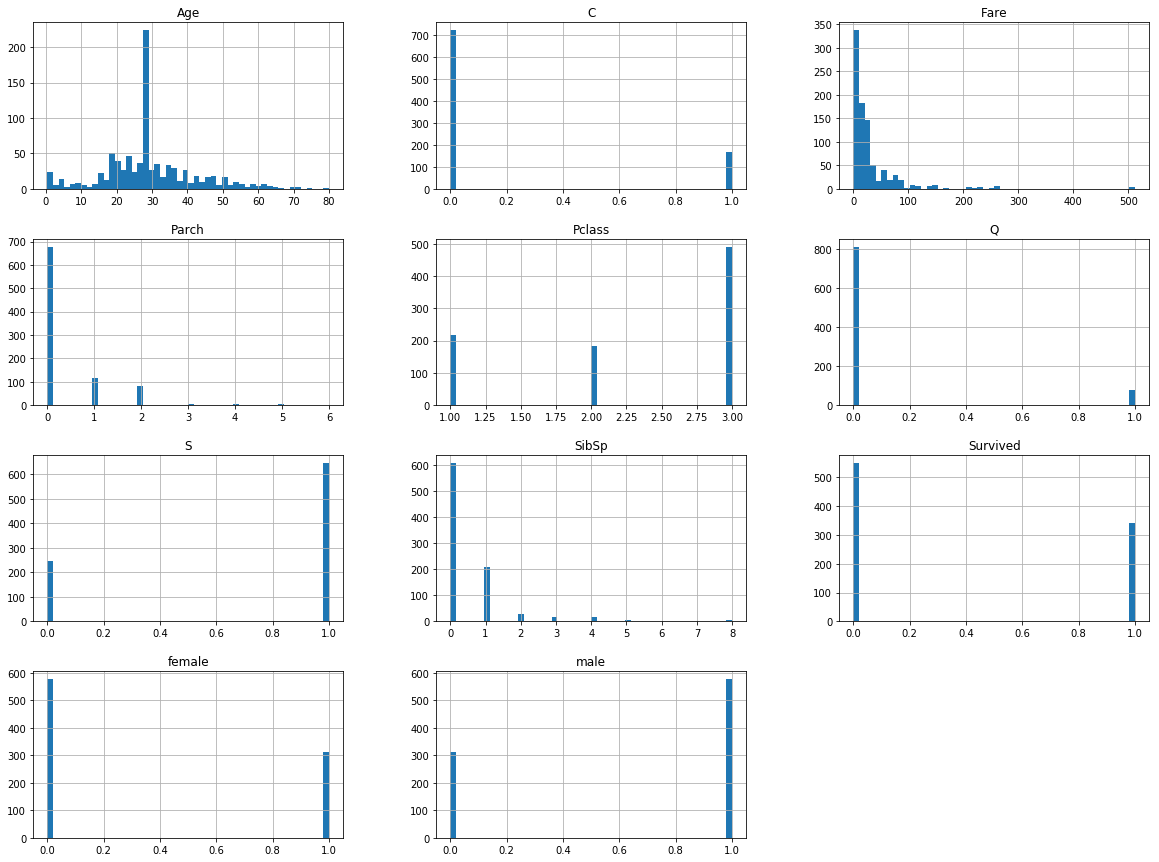

In [15]:
X.hist(bins = 50, figsize = (20,15))

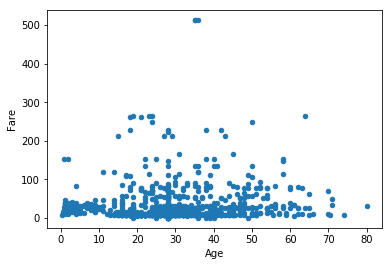

In [16]:
X.plot(kind = 'scatter', x = 'Age', y = 'Fare')

In [17]:
corr_matrix = X.corr()

In [18]:
corr_matrix

,Survived,Pclass,Age,SibSp,Parch,Fare,male,female,S,C,Q
Survived,1.000000,-0.338481,-0.064910,-0.035322,0.081629,0.257307,-0.543351,0.543351,-0.149683,0.168240,0.003650
Pclass,-0.338481,1.000000,-0.339898,0.083081,0.018443,-0.549500,0.131900,-0.131900,0.074053,-0.243292,0.221009
Age,-0.064910,-0.339898,1.000000,-0.233296,-0.172482,0.096688,0.081163,-0.081163,-0.006729,0.030248,-0.031415
SibSp,-0.035322,0.083081,-0.233296,1.000000,0.414838,0.159651,-0.114631,0.114631,0.068734,-0.059528,-0.026354
Parch,0.081629,0.018443,-0.172482,0.414838,1.000000,0.216225,-0.245489,0.245489,0.060814,-0.011069,-0.081228
Fare,0.257307,-0.549500,0.096688,0.159651,0.216225,1.000000,-0.182333,0.182333,-0.162184,0.269335,-0.117216
male,-0.543351,0.131900,0.081163,-0.114631,-0.245489,-0.182333,1.000000,-1.000000,0.119224,-0.082853,-0.074115
female,0.543351,-0.131900,-0.081163,0.114631,0.245489,0.182333,-1.000000,1.000000,-0.119224,0.082853,0.074115
S,-0.149683,0.074053,-0.006729,0.068734,0.060814,-0.162184,0.119224,-0.119224,1.000000,-0.782742,-0.499421
C,0.168240,-0.243292,0.030248,-0.059528,-0.011069,0.269335,-0.082853,0.082853,-0.782742,1.000000,-0.148258


# Predict 

In [19]:
test_df = pd.read_csv('data/test.csv')
passId = test_df['PassengerId']
test_df = pipeline.fit_transform(test_df)

Encode:  Sex
Category:  Index(['male', 'female'], dtype='object')
Encode:  Embarked
Category:  Index(['Q', 'S', 'C'], dtype='object')


In [20]:
y = X['Survived']
X.drop(columns = ['Survived'], inplace = True)

## K-neighbors 

In [21]:
kclf = KNeighborsClassifier(n_neighbors = 12)

In [22]:
score = cross_val_score(kclf, X, y, cv = 5, scoring = 'accuracy')
score.mean()

0.7004864197189363

In [23]:
predict = cross_val_predict(kclf, X, y, cv = 5)
confusion_matrix(y, predict)

array([[472,  77],
       [190, 152]], dtype=int64)

In [24]:
precision_score(y, predict)

0.6637554585152838

In [25]:
recall_score(y, predict)

0.4444444444444444

In [26]:
f1_score(y, predict)

0.5323992994746058

##  Random Forest

In [27]:
fclf = RandomForestClassifier(random_state = 42)

In [28]:
params = {'n_estimators': [10, 50, 100, 200]}

In [29]:
grid_search = GridSearchCV(fclf, params,cv=5)
grid_search.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [30]:
print("Best params:", grid_search.best_params_)

Best params: {'n_estimators': 10}


In [31]:
y_prob = cross_val_predict(grid_search.best_estimator_, X, y, cv=5, method = "predict_proba")

In [32]:
y_scores = y_prob[:, 1]

In [33]:
fpr, tpr, thresholds = roc_curve(y, y_scores)

In [34]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

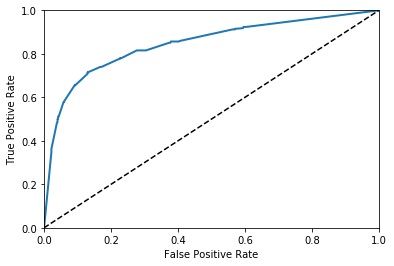

In [35]:
plot_roc_curve(fpr, tpr, 'ROC Random Forest')
plt.show()

In [36]:
roc_auc_score(y, y_scores)

0.8457003163646822

In [39]:
y_predict = grid_search.best_estimator_.predict(test_df)

## Create submissions

In [52]:
submission_df = pd.DataFrame()

In [53]:
submission_df['PassengerId'] = passId
submission_df['Survived'] = y_predict

In [55]:
submission_df.to_csv('subm.csv', index = False)